# Chọn đặc trưng (Feature Selection)

Mục tiêu của notebook này là thực hiện chọn đặc trưng. Có hai phương pháp sẽ được sử dụng để thực hiện việc chọn đặc trưng:

Random forest – Các đặc trưng sẽ được xếp hạng dựa trên điểm quan trọng (importance score) do bộ phân loại random forest cung cấp và chọn ra $n$ đặc trưng hàng đầu

Brute force – Huấn luyện các mô hình học máy bằng cách sử dụng số lượng đặc trưng khác nhau. Độ chính xác của mỗi mô hình tương ứng với số lượng đặc trưng sẽ được ghi lại để chọn ra tập đặc trưng ngắn gọn và hiệu quả nhất.

In [4]:
# nhập tất cả các gói cần thiết

# các gói cơ bản để xử lý dữ liệu
import os       # để tạo thư mục và xóa tệp
import pandas as pd
import numpy as np 
import random # nhập gói random để đặt giá trị seed ngẫu nhiên

# các mô-đun cho học máy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# các mô-đun để phân tích kết quả huấn luyện
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# tắt các cảnh báo từ thư viện sklearn
import warnings
warnings.filterwarnings('ignore')

# đặt seed ngẫu nhiên để đảm bảo kết quả có thể tái tạo
random.seed(10)
np.random.seed(10)

Tải bộ dữ liệu

Vì bộ dữ liệu khá lớn, chỉ sử dụng 10% dữ liệu cho việc chọn đặc trưng

In [7]:
# đọc bộ dữ liệu từ các tệp
ids2017 = pd.read_csv('Dataset/dataset_cleaned/CIC-IDS2017.csv')
ids2017 = ids2017.sample(frac=0.1).reset_index(drop=True)
ids2017.shape

(64976, 78)

## Bước 2. Chọn đặc trưng bằng rừng ngẫu nhiên

Trong bước này, các đặc trưng sẽ được chọn bằng cách sử dụng thuật toán rừng ngẫu nhiên. Đầu tiên, một mô hình rừng ngẫu nhiên sẽ được huấn luyện. Sau đó, các đặc trưng sẽ được xếp hạng dựa trên điểm quan trọng do mô hình rừng ngẫu nhiên cung cấp và $n$ đặc trưng hàng đầu sẽ được chọn. Trong bước này, các đặc trưng sẽ được chọn bằng cách sử dụng thuật toán rừng ngẫu nhiên. Đầu tiên, một mô hình rừng ngẫu nhiên sẽ được huấn luyện. Sau đó, các đặc trưng sẽ được xếp hạng dựa trên điểm quan trọng do mô hình rừng ngẫu nhiên cung cấp và $n$ đặc trưng hàng đầu sẽ được chọn.

In [10]:
ids2017_X = ids2017.drop('Label', axis=1).copy()
ids2017_y = ids2017['Label'].copy()

In [12]:
X_columns = ids2017_X.columns
ids2017_X = StandardScaler().fit_transform(ids2017_X)

In [14]:
%%time
rfc = RandomForestClassifier()

# Huấn luyện bộ phân loại Random Forest trên tập huấn luyện
rfc.fit(ids2017_X, ids2017_y)

CPU times: total: 8.7 s
Wall time: 8.71 s


RandomForestClassifier()

In [16]:
# Trích xuất điểm quan trọng từ bộ phân loại Random Forest
score = np.round(rfc.feature_importances_, 3)
importance = pd.DataFrame({'feature': X_columns, 
                            'importance': score})
importance = importance.sort_values('importance', ascending=False).set_index('feature')

print(f"Top 20 features: \n{importance[:20]}")

plt.rcParams['figure.figsize'] = (12, 4)
importance.plot.bar()

Top 20 features: 
                             importance
feature                                
Bwd Packet Length Std             0.075
Average Packet Size               0.067
Max Packet Length                 0.047
Packet Length Variance            0.044
Packet Length Std                 0.043
Avg Bwd Segment Size              0.038
Packet Length Mean                0.037
Destination Port                  0.037
Init_Win_bytes_forward            0.031
Fwd Packet Length Mean            0.029
Init_Win_bytes_backward           0.029
Subflow Bwd Bytes                 0.028
Bwd Packet Length Max             0.028
Total Length of Bwd Packets       0.027
Bwd Packet Length Mean            0.026
Fwd Packet Length Max             0.026
Bwd Packet Length Min             0.025
Subflow Fwd Bytes                 0.024
Avg Fwd Segment Size              0.020
Fwd Header Length                 0.018


<Axes: xlabel='feature'>

### Lưu các đặc trưng - Save the features

In [19]:
def save_feature(features: pd.Series, dataset_name: str, algorithm: str, tag: str = ""):
    
    feature_count = features.shape[0]

    if not(tag == ""):
        tag = "_" + tag
    
    directory = 'Dataset/features_selected'
    file_name = f"{dataset_name}_{algorithm}_{feature_count}{tag}"
    
    # create directory to save the file
    os.makedirs(directory, exist_ok=True)
    
    features.to_csv(f"{directory}/{file_name}.csv", index=False, columns=None)

    print(f"Các đặc trưng đã được lưu tại {directory}/{file_name}.csv")

In [21]:
features = pd.Series(importance.index[:20], dtype='str')
save_feature(features=features, 
            dataset_name='CIC-IDS2017', 
            algorithm='RandomForestClassifier')

The features have been saved in Dataset/features_selected/CIC-IDS2017_RandomForestClassifier_20.csv


## Bước 3. Brute force

Sau khi chọn các đặc trưng bằng rừng ngẫu nhiên, số lượng đặc trưng sẽ được giảm thêm bằng phương pháp brute force. Phương pháp này khá đơn giản, các mô hình học máy sẽ được huấn luyện với các số lượng đặc trưng khác nhau. Bộ đặc trưng mang lại độ chính xác tương đương với số lượng đặc trưng ít nhất sẽ là bộ đặc trưng cuối cùng.

Bắt đầu từ đặc trưng xếp hạng thứ $1^{st}$, các đặc trưng sẽ được thêm vào cho đến khi tất cả $n$ đặc trưng được sử dụng. Đối với bộ dữ liệu CIC-IDS2017, $n$ bằng $20$.

In [24]:
columns = features.tolist() +  ['Label']

ids2017 = ids2017[columns]
ids2017.shape

(64976, 21)

In [26]:
ids2017_X = ids2017.drop('Label', axis=1).copy()
ids2017_y = ids2017['Label'].copy()

ids2017_train_X, ids2017_test_X, ids2017_train_y, ids2017_test_y = train_test_split(ids2017_X, ids2017_y, test_size=0.3)

In [28]:
# Định nghĩa các mô hình học máy mà không tối ưu hóa siêu tham số
models = {
    'Decision Tree': tree.DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB(),
    'Artificial Neural Network': MLPClassifier(hidden_layer_sizes=(40), max_iter=500),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(12, 12, 12), max_iter=500)
}

Trong bước này, các mô hình học máy sẽ được định nghĩa mà không thực hiện tối ưu hóa các siêu tham số. Điều này có nghĩa là các mô hình sẽ được sử dụng với các giá trị siêu tham số mặc định, thay vì tìm kiếm và điều chỉnh các siêu tham số sao cho đạt hiệu quả tối ưu.

In [32]:
feature_set = []
scalar = StandardScaler()
scores = []

for feature in features:
    feature_set.append(feature)
    print(f"Đã thêm tính năng {len(feature_set)} ({feature})...")\
    
    test_X = ids2017_test_X[feature_set]
    train_X = ids2017_train_X[feature_set]

    # scale the dataset
    train_X_scaled = scalar.fit(train_X)
    train_X_scaled = scalar.transform(train_X)
    test_X_scaled = scalar.transform(test_X)

    score_temp = [len(feature_set)]

    for model in models:
        clf = models[model]
        clf.fit(train_X_scaled, ids2017_train_y)

        prediction = clf.predict(test_X_scaled)
        accuracy = metrics.accuracy_score(ids2017_test_y, prediction)

        score_temp.append(accuracy)

    scores.append(score_temp)


scores = np.array(scores)

Added feature 1 (Bwd Packet Length Std)...
Added feature 2 (Average Packet Size)...
Added feature 3 (Max Packet Length)...
Added feature 4 (Packet Length Variance)...
Added feature 5 (Packet Length Std)...
Added feature 6 (Avg Bwd Segment Size)...
Added feature 7 (Packet Length Mean)...
Added feature 8 (Destination Port)...
Added feature 9 (Init_Win_bytes_forward)...
Added feature 10 (Fwd Packet Length Mean)...
Added feature 11 (Init_Win_bytes_backward)...
Added feature 12 (Subflow Bwd Bytes)...
Added feature 13 (Bwd Packet Length Max)...
Added feature 14 (Total Length of Bwd Packets)...
Added feature 15 (Bwd Packet Length Mean)...
Added feature 16 (Fwd Packet Length Max)...
Added feature 17 (Bwd Packet Length Min)...
Added feature 18 (Subflow Fwd Bytes)...
Added feature 19 (Avg Fwd Segment Size)...
Added feature 20 (Fwd Header Length)...


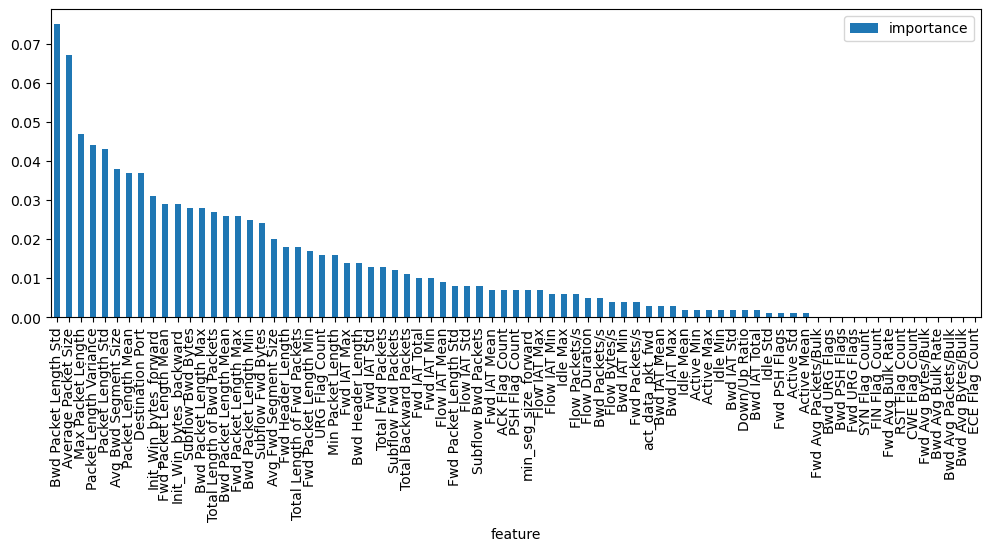

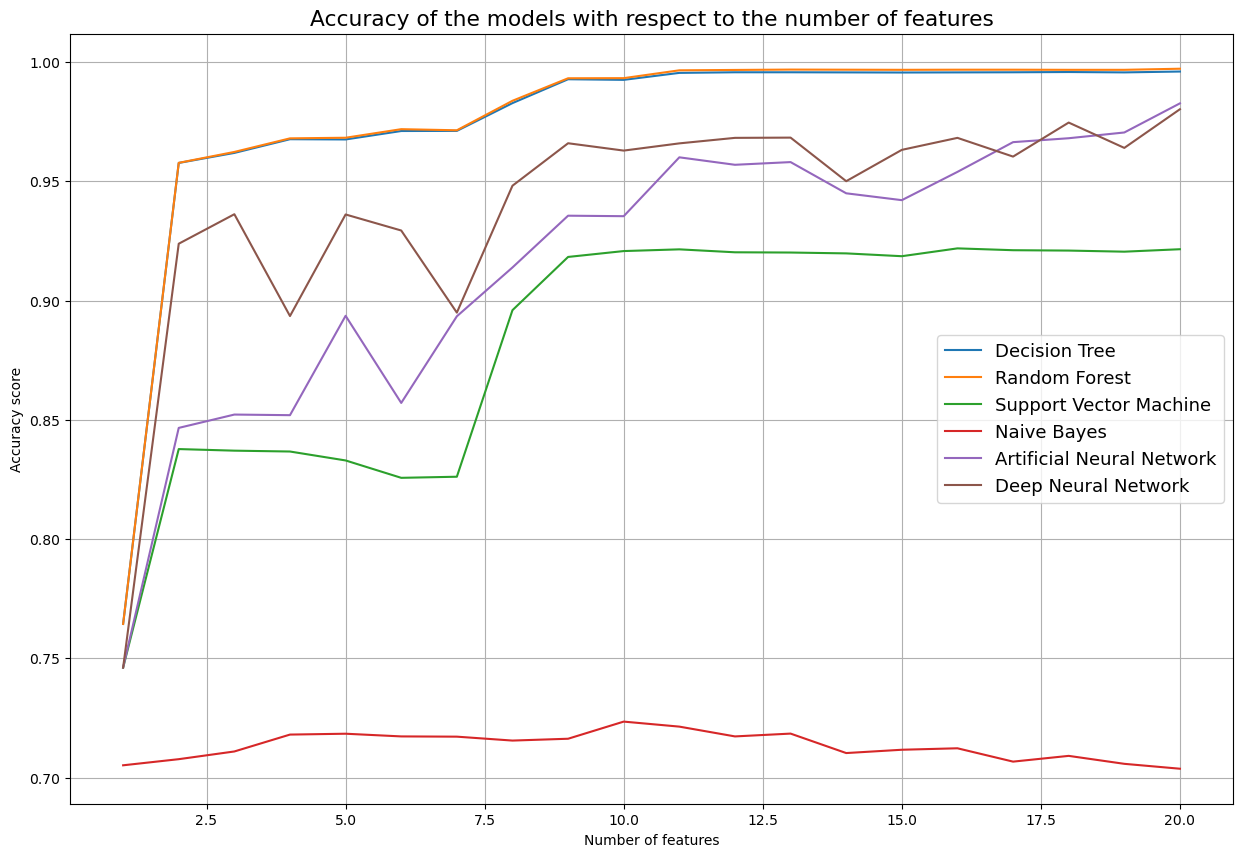

In [34]:
plt.figure(figsize=(15, 10))
for index, model in enumerate(models):
    plt.plot(scores.T[0], scores.T[index + 1], label=model)

plt.rcParams.update({'font.size': 13})
plt.title('Accuracy of the models with respect to the number of features')
plt.xlabel('Number of features')
plt.ylabel('Accuracy score')
plt.legend()
plt.grid()
plt.show()